# Magic Squares Game Optimization

In this notebook, we demonstrate the use of variational quantum optimization (VQO) to find optimal quantum strategies for the magic squares game.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import qnetvo as qnet

## Finding the Perfect Winning Probability

The magic squares game and the optimal quantum strategy are described in https://arxiv.org/abs/quant-ph/0407221.
The magic squares cost function minimizes $-P_{\text{Win}}$ and is outlined in more detail in the `qnetvo` docs.

### Optimizing Measurments for Fixed State Preparations

In this section, we will optimize arbitrary two-qubit measurements against different state preparations including, a 4-qubit GHZ state, two copies of a Bell state, a single Bell state, and no entanglement.
Each optimization will be performed on 4-qubit wires.

In [2]:
bell_copies_prep_node = [
    qnet.PrepareNode(1, [0,1,2,3], qnet.bell_state_copies, 0)
]
ghz_prep_node = [
    qnet.PrepareNode(1, [0,1,2,3], qnet.ghz_state, 0)
]
max_entangled_prep_node = [
    qnet.PrepareNode(1, [0,2], qnet.max_entangled_state, 3)
]
classical_prep_node = [
    qnet.PrepareNode(1, [0,1,2,3], lambda settings, wires: None, 0)
]

measure_nodes = [
    qnet.MeasureNode(3, 4, [0,1], qml.ArbitraryUnitary, 15),
    qnet.MeasureNode(3, 4, [2,3], qml.ArbitraryUnitary, 15),
]

classical_ansatz = qnet.NetworkAnsatz(classical_prep_node, measure_nodes)
max_entangled_ansatz = qnet.NetworkAnsatz(max_entangled_prep_node, measure_nodes)
ghz_state_ansatz = qnet.NetworkAnsatz(ghz_prep_node, measure_nodes)
bell_copies_ansatz = qnet.NetworkAnsatz(bell_copies_prep_node, measure_nodes)

Next, we perform gradient descent to minimze the magic squares cost function with respect to each of the above state preparations.

## Classical State Preparation

In [3]:
%%time
np.random.seed(2)

classical_opt_dict = qnet.gradient_descent(
    qnet.magic_squares_game_cost(classical_ansatz),
    classical_ansatz.rand_scenario_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", classical_opt_dict["opt_score"])

/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


opt score :  0.8888798713795558
CPU times: user 30.6 s, sys: 102 ms, total: 30.7 s
Wall time: 30.7 s


## 4-Qubit GHZ State Preparation

In [4]:
%%time
np.random.seed(2)

ghz_state_opt_dict = qnet.gradient_descent(
    qnet.magic_squares_game_cost(ghz_state_ansatz),
    ghz_state_ansatz.rand_scenario_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", ghz_state_opt_dict["opt_score"])

opt score :  0.955244701837105
CPU times: user 31.9 s, sys: 133 ms, total: 32 s
Wall time: 32 s


## Arbitrary Maximally Entangled 2-Qubit State Preparation

In [11]:
%%time
np.random.seed(1)

max_entangled_opt_dict = qnet.gradient_descent(
    qnet.magic_squares_game_cost(max_entangled_ansatz),
    max_entangled_ansatz.rand_scenario_settings(),
    step_size=2,
    num_steps=100,
    sample_width=5,
    verbose=True
)

print("opt score : ", max_entangled_opt_dict["opt_score"])

iteration :  0 , score :  0.4851396844059199
elapsed time :  0.3537461757659912
iteration :  5 , score :  0.658387385514295
elapsed time :  0.2553107738494873
iteration :  10 , score :  0.7032587972803029
elapsed time :  0.3224608898162842
iteration :  15 , score :  0.7332214324813751
elapsed time :  0.3196909427642822
iteration :  20 , score :  0.7604316515863432
elapsed time :  0.3316459655761719
iteration :  25 , score :  0.7851542492948242
elapsed time :  0.3175520896911621
iteration :  30 , score :  0.8094369348466018
elapsed time :  0.32849693298339844
iteration :  35 , score :  0.8443960620540354
elapsed time :  0.32380127906799316
iteration :  40 , score :  0.884056717593187
elapsed time :  0.3567368984222412
iteration :  45 , score :  0.9084930323464833
elapsed time :  0.33891892433166504
iteration :  50 , score :  0.9241414919537695
elapsed time :  0.33577704429626465
iteration :  55 , score :  0.9349621587689513
elapsed time :  0.34005188941955566
iteration :  60 , score :  

## Two Copies of a Bell State

In [6]:
%%time
np.random.seed(2)

bell_copies_opt_dict = qnet.gradient_descent(
    qnet.magic_squares_game_cost(bell_copies_ansatz),
    bell_copies_ansatz.rand_scenario_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", bell_copies_opt_dict["opt_score"])

opt score :  0.999894033930867
CPU times: user 30.7 s, sys: 101 ms, total: 30.8 s
Wall time: 30.8 s


## Plotting Optimization Data

The optimization data is shown in the plot below.
As expected, we find that the classical ansatz to achieve the classical bound and the two Bell states to achieve the quantum bound.
We find that a single maximally entangeld 2-qubit state provides an improvement over the lower bound.
Similarly, a 4-qubit GHZ state achieves the same score as a 2-qubit maximally entangled state.

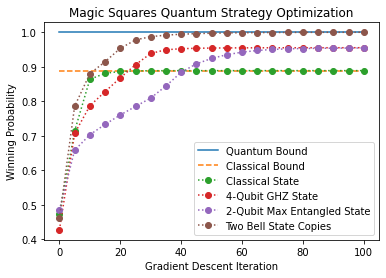

In [12]:
samples = bell_copies_opt_dict["samples"]

plt.plot(samples, [1] * len(samples), label = "Quantum Bound")
plt.plot(samples, [8/9] * len(samples), "--", label = "Classical Bound")

plt.plot(samples, classical_opt_dict["scores"], "o:", label="Classical State")
plt.plot(samples, ghz_state_opt_dict["scores"], "o:", label = "4-Qubit GHZ State")
plt.plot(samples, max_entangled_opt_dict["scores"], "o:", label="2-Qubit Max Entangled State")
plt.plot(samples, bell_copies_opt_dict["scores"], "o:", label = "Two Bell State Copies")

plt.title("Magic Squares Quantum Strategy Optimization")
plt.xlabel("Gradient Descent Iteration")
plt.ylabel("Winning Probability")
plt.legend()
plt.show()